# Part 2: Data Analysis

## Step 1: Install necessary modules

In [2]:
pip install numpy pandas matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


## Step 2: Build Functions

### 2.1 Import modules

In [78]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
import math

### 2.2 Data extraction

In [64]:
# Input: .csv files containing the raw data directly downloaded from pavlovia.org
# Output: Dataframe file with selected items for all participants 
def Data2Df(categoryList):    
    dfRaw = pd.DataFrame()
    
    for category in categoryList:
        directory = category + "/data/"

        for root,dirs,files in os.walk(directory):
            for file in files:
                if file.endswith(".csv"):
                    dfParticipant = pd.read_csv(directory + file)
                
                    # add category column
                    dfParticipant['category'] = category
                    
                    # add image pair
                    if category == "flowers":
                        dfParticipant['image_pair'] = [i for i in range(400)]
                    elif category == 'houses':
                        dfParticipant['image_pair'] = [i for i in range(400, 800)]
                    else:
                        dfParticipant['image_pair'] = [i for i in range(800, 1211)]
                        
                    dfRaw = dfRaw.append(dfParticipant)
                    
    # filter out useful information from raw data
    df = dfRaw[['key_resp_2.keys', 
                'key_resp_2.rt', 
                'image_left', 
                'image_right', 
                'trial_num', 
                'participant', 
                'date',
                'category',
                'image_pair']]
    
    # change column name to better organize data
    df = df.rename(columns={'key_resp_2.keys': 'score', 'key_resp_2.rt': 'time'})
    
    # Disable warning due to potential 'chained' assignments in Dataframe
    pd.options.mode.chained_assignment = None 
    df['score'] = df['score'].replace(['z', 'm'],[1, 0])
    
    return df

In [2]:
# Input: Dataframe from the output of Data2Df function
# Output: Dataframe containing the score of each image
def Df2Score(df):
    # create score table for left image and right image, respectively
    # the current score is calculated with basic average score of each
    # image, more advanced math model can be applied to better differentiate 
    # the performance of each image.
    key = df['score']

    leftScore = key
    rightScore = key.replace([1,0], [0,1])

    # create image to score dataframe
    imageDir = list(df['image_left']) + list(df['image_right'])
    score = list(leftScore) + list(rightScore)
    dfScore = pd.DataFrame({'imageDir':imageDir, 'score':score})
    dfScore = dfScore.groupby('imageDir').mean()
    
    return dfScore

In [3]:
def groupbyItem(df, item):
    dfItem = df.groupby(item).mean()
    dfItem = dfItem[['score', 'time']]
    dfItem.reset_index(inplace=True)
    
    return dfItem

## Step 3: Data reliability analysis

### Reliability is very important to a survey-wised study. In this study, the left images and right images are well balanced: every single image is displayed the same times on left and right positions.

### 3.1 Score distribution

#### Every image appears at least once on both left and right positions, so a groupby function on left_image can cover all the images. As the images are randomly selected, we assume the average score of all images are in a normal distribution with an average 0.5.

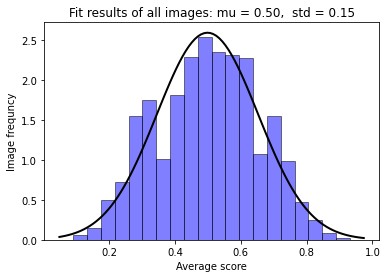

In [7]:
df = Data2Df(['flowers', 'houses', 'paints'])
dfScore = Df2Score(df)

data = dfScore['score']

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=20, density=True, alpha=0.5, color='blue', edgecolor = 'black')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results of all images: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Average score')
plt.ylabel('Image frequncy')

plt.show()

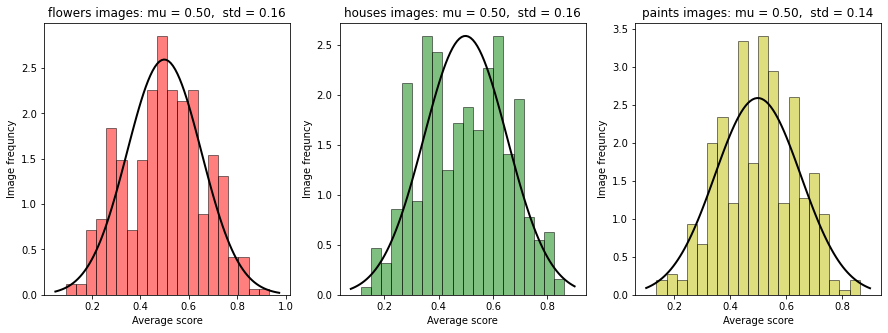

In [10]:
dfFlower = Df2Score(df.loc[df['category'] == 'flowers'])
dataf = dfFlower['score']
dfHouse = Df2Score(df.loc[df['category'] == 'houses'])
datah = dfHouse['score']
dfPaint = Df2Score(df.loc[df['category'] == 'paints'])
datap = dfPaint['score']

# Fit a normal distribution to the data:
mu1, std1 = norm.fit(dataf)
mu2, std2 = norm.fit(datah)
mu3, std3 = norm.fit(datap)

# Plot the histogram.
plt.figure(13, figsize = (15,5))

plt.subplot(131)
plt.hist(dataf, bins=20, density=True, alpha=0.5, color='r', edgecolor = 'black')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "flowers images: mu = %.2f,  std = %.2f" % (mu1, std1)
plt.title(title)
plt.xlabel('Average score')
plt.ylabel('Image frequncy')

plt.subplot(132)
plt.hist(datah, bins=20, density=True, alpha=0.5, color='g', edgecolor = 'black')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "houses images: mu = %.2f,  std = %.2f" % (mu2, std2)
plt.title(title)
plt.xlabel('Average score')
plt.ylabel('Image frequncy')

plt.subplot(133)
plt.hist(datap, bins=20, density=True, alpha=0.5, color='y', edgecolor = 'black')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "paints images: mu = %.2f,  std = %.2f" % (mu3, std3)
plt.title(title)
plt.xlabel('Average score')
plt.ylabel('Image frequncy')

plt.show()

#### Because our measurements are binary (0 or 1), the null hypothesis is binomially distributed with the following parameters: n=1211, p=.5. Because n is large we can approximate the distribution with a normal distribution with a mean of mu = np = 605.5 and standard deviation sigma = sqrt(np(1-p)) = 17.4. We can now conduct a z-test.

#### Null hypothesis is the score distribution for a single subject is along N(605.5, 17.4)
#### Alternative hypothesis is the average score is not equal to 605,5
#### Alpha level is: 0.05
#### Critical value of test statistics: z = 1.96 for two tailed test.

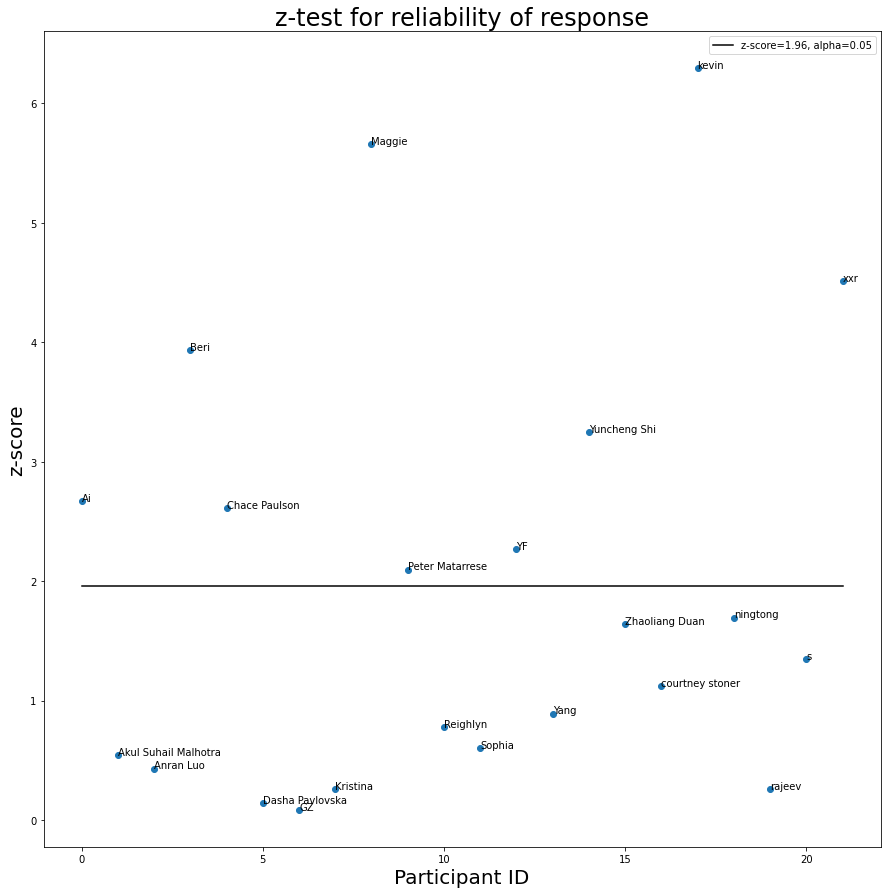

In [43]:
def zScore(mu):
    zscore = abs(mu - 605.5) / 17.4
    return zscore

dfParticipant = df.groupby('participant').sum()
zscore = dfParticipant.score.map(zScore)

subjectID = np.arange(22)
plt.figure(figsize=(15, 15))
plt.scatter(subjectID, zscore, label='_nolegend_')

for i, txt in enumerate(zscore.index):
    plt.annotate(txt, (subjectID[i], zscore[i]))

zStandard = np.array([1.96 for i in range(22)])
plt.plot(subjectID, zStandard, color = 'black', label = 'z-score=1.96, alpha=0.05')
plt.legend()

fontsize = 20
plt.title("z-test for reliability of response", fontsize=24)
plt.xlabel('Participant ID', fontsize=fontsize)
plt.ylabel('z-score', fontsize=fontsize)
plt.show()

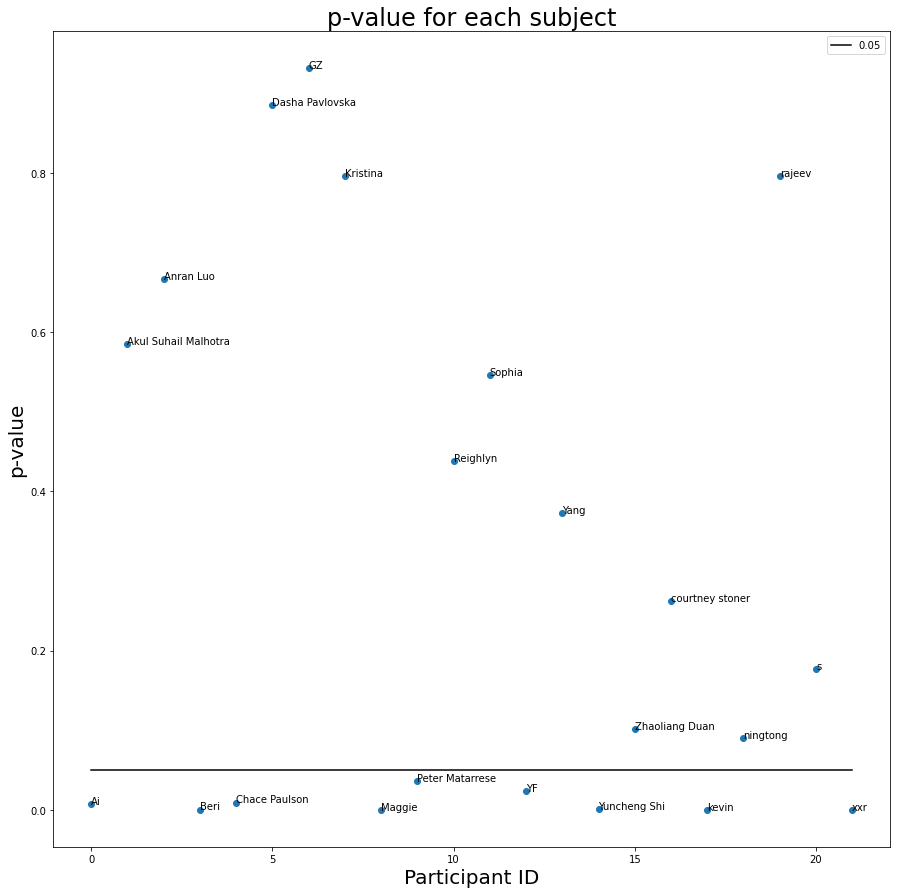

In [49]:
# P-value
p_values = scipy.stats.norm.sf(abs(zscore))*2

subjectID = np.arange(22)
plt.figure(figsize=(15, 15))
plt.scatter(subjectID, p_values, label='_nolegend_')

for i, txt in enumerate(zscore.index):
    plt.annotate(txt, (subjectID[i], p_values[i]))

pStandard = np.array([0.05 for i in range(22)])
plt.plot(subjectID, pStandard, color = 'black', label = '0.05')
plt.legend()

fontsize = 20
plt.title("p-value for each subject", fontsize=24)
plt.xlabel('Participant ID', fontsize=fontsize)
plt.ylabel('p-value', fontsize=fontsize)
plt.show()

In [62]:
### Data filtering
validateSubject = ['GZ', 'Dasha Pavlovska', 'Kristina', 'rajeev', 'Anran Luo', 'Akul Suhail Malhotra', 'Sophia', 'Reighlyn', 'Yang', 'courtney stoner', 's', 'Zhaoliang Duan', 'ningtong']
df = df.loc[df['participant'].isin (validateSubject)]
df

,score,time,image_left,image_right,trial_num,participant,date,category
0,1,4.121530,flowers/images/125.jpg,flowers/images/165.jpg,1,Akul Suhail Malhotra,2020-11-21_13h28.30.988,flowers
1,0,5.532645,flowers/images/168.jpg,flowers/images/195.jpg,2,Akul Suhail Malhotra,2020-11-21_13h28.30.988,flowers
2,0,2.224095,flowers/images/114.jpg,flowers/images/131.jpg,3,Akul Suhail Malhotra,2020-11-21_13h28.30.988,flowers
3,0,1.384490,flowers/images/110.jpg,flowers/images/241.jpg,4,Akul Suhail Malhotra,2020-11-21_13h28.30.988,flowers
4,0,1.067200,flowers/images/157.jpg,flowers/images/170.jpg,5,Akul Suhail Malhotra,2020-11-21_13h28.30.988,flowers
...,...,...,...,...,...,...,...,...
406,1,1.165540,paints/images/236.jpg,paints/images/369.jpg,207,Zhaoliang Duan,2020-11-20_11h57.54.954,paints
407,1,2.876085,paints/images/219.jpg,paints/images/136.jpg,208,Zhaoliang Duan,2020-11-20_11h57.54.954,paints
408,1,0.760545,paints/images/306.jpg,paints/images/239.jpg,209,Zhaoliang Duan,2020-11-20_11h57.54.954,paints
409,0,0.985545,paints/images/108.jpg,paints/images/259.jpg,210,Zhaoliang Duan,2020-11-20_11h57.54.954,paints


### 3.2 Time distribution

(array([2.6619e+04, 1.2000e+01, 1.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.        ,  37.23092525,  74.4618505 , 111.69277575,
        148.923701  , 186.15462625, 223.3855515 , 260.61647675,
        297.847402  , 335.07832725, 372.3092525 , 409.54017775,
        446.771103  , 484.00202825, 521.2329535 , 558.46387875,
        595.694804  , 632.92572925, 670.1566545 , 707.38757975,
        744.618505  ]),
 <a list of 20 Patch objects>)

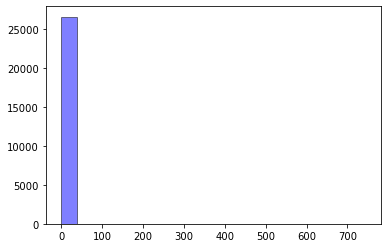

In [73]:
df = Data2Df(['flowers', 'houses', 'paints'])
dfTime = df[['participant', 'time', 'image_left', 'image_right', 'image_pair']]

data = dfTime['time']

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=20, density=False, alpha=0.5, color='blue', edgecolor = 'black')

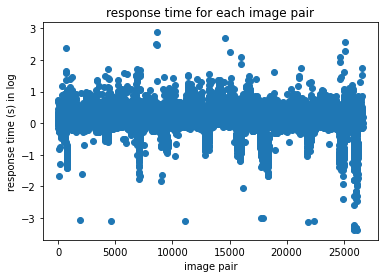

In [90]:
plt.scatter(np.arange(len(data)), np.log10(data))
plt.title("response time for each image pair")
plt.xlabel('image pair')
plt.ylabel('response time (s) in log')
plt.show()

In [88]:
np.log10(0.01)

-2.0

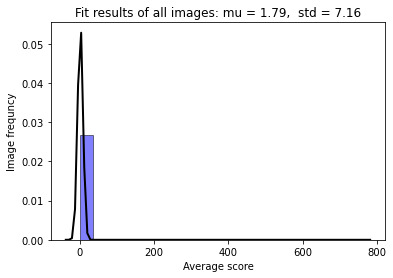

In [66]:
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results of all images: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Average score')
plt.ylabel('Image frequncy')

plt.show()

## Step 3: Preliminary Visualization

### 3.1 Plots

/Users/loni/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


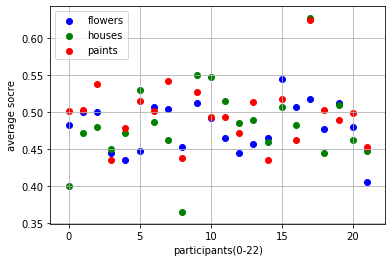

In [4]:
# Plot the average score of the 22 participants
# Note: 1. this is the result for all 3 categories
#       2. for each image pair, the participant gets 1 score if he/she select 
#          the left image, and 0 score if he/she select the right image

# flowers
categories = ['flowers']
df = Data2Df(categories)
fDf = groupbyItem(df, 'participant')
x1 = fDf.index.to_numpy()
y1 = fDf.score.to_numpy()
z1 = fDf.time.to_numpy()

# houses
categories = ['houses']
df = Data2Df(categories)
hDf = groupbyItem(df, 'participant')
x2 = hDf.index.to_numpy()
y2 = hDf.score.to_numpy()
z2 = hDf.time.to_numpy()

# paints
categories = ['paints']
df = Data2Df(categories)
pDf = groupbyItem(df, 'participant')
x3 = pDf.index.to_numpy()
y3 = pDf.score.to_numpy()
z3 = pDf.time.to_numpy()


plt.scatter(x1, y1, c='b', label = 'flowers')
plt.scatter(x2, y2, c='g', label = 'houses')
plt.scatter(x3, y3, c='r', label = 'paints')

plt.xlabel('participants(0-22)')
plt.ylabel('average socre')
plt.legend()
plt.grid()
plt.show()

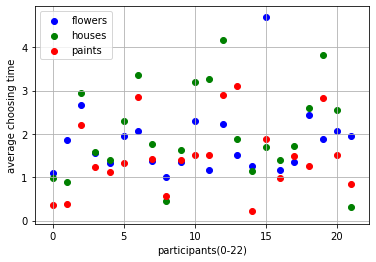

In [5]:
plt.scatter(x1, z1, c='b', label = 'flowers')
plt.scatter(x2, z2, c='g', label = 'houses')
plt.scatter(x3, z3, c='r', label = 'paints')

plt.xlabel('participants(0-22)')
plt.ylabel('average choosing time')
plt.legend()
plt.grid()
plt.show()

### 3.2 Correlation analysis

In [7]:
categories = ['flowers','houses','paints']
df = Data2Df(categories)
participantDf = groupbyItem(df, 'participant')
participantDf.corr(method = 'kendall')

,score,time
score,1.000000,0.329719
time,0.329719,1.000000


In [8]:
df

,score,time,image_left,image_right,trial_num,participant,date,category
0,1,5.310000,flowers/images/125.jpg,flowers/images/165.jpg,1,Ai,2020-11-21_22h07.13.545,flowers
1,0,4.539000,flowers/images/168.jpg,flowers/images/195.jpg,2,Ai,2020-11-21_22h07.13.545,flowers
2,1,1.846000,flowers/images/114.jpg,flowers/images/131.jpg,3,Ai,2020-11-21_22h07.13.545,flowers
3,1,1.767000,flowers/images/110.jpg,flowers/images/241.jpg,4,Ai,2020-11-21_22h07.13.545,flowers
4,1,2.042000,flowers/images/157.jpg,flowers/images/170.jpg,5,Ai,2020-11-21_22h07.13.545,flowers
...,...,...,...,...,...,...,...,...
406,1,3.173355,paints/images/236.jpg,paints/images/369.jpg,207,Anran Luo,2020-11-22_14h53.35.645,paints
407,0,2.791595,paints/images/219.jpg,paints/images/136.jpg,208,Anran Luo,2020-11-22_14h53.35.645,paints
408,0,0.991650,paints/images/306.jpg,paints/images/239.jpg,209,Anran Luo,2020-11-22_14h53.35.645,paints
409,1,1.056805,paints/images/108.jpg,paints/images/259.jpg,210,Anran Luo,2020-11-22_14h53.35.645,paints


## Step 4: Export label files for deep learning

In [9]:
# Input: Dataframe from the output of Data2Df function
# Output: Dataframe containing the score of each image
def Df2Score(df):
    # create score table for left image and right image, respectively
    # the current score is calculated with basic average score of each
    # image, more advanced math model can be applied to better differentiate 
    # the performance of each image.
    key = df['score']

    leftScore = key
    rightScore = key.replace([1,0], [0,1])

    # create image to score dataframe
    imageDir = list(df['image_left']) + list(df['image_right'])
    score = list(leftScore) + list(rightScore)
    dfScore = pd.DataFrame({'imageDir':imageDir, 'score':score})
    dfScore = dfScore.groupby('imageDir').mean()
    
    return dfScore

In [11]:
dfScore = Df2Score(df)
print(dfScore)
dfScore.to_csv('score.csv')

                           score
imageDir                        
flowers/images/0.jpg    0.363636
flowers/images/1.jpg    0.227273
flowers/images/10.jpg   0.431818
flowers/images/100.jpg  0.477273
flowers/images/101.jpg  0.454545
...                          ...
paints/images/95.jpg    0.363636
paints/images/96.jpg    0.500000
paints/images/97.jpg    0.568182
paints/images/98.jpg    0.613636
paints/images/99.jpg    0.477273

[1151 rows x 1 columns]
